In [204]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader    #⭐
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import MinMaxScaler, RobustScaler

import FinanceDataReader as fdr

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.figsize"] = (12, 6)

In [205]:
stock = fdr.DataReader('005930')
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2013-03-18,29200,29200,28680,28900,528791,NaN
2013-03-19,29000,29839,28960,29500,279542,0.020761
2013-03-20,29200,29700,29120,29200,270315,-0.010169
2013-03-21,29220,29480,29119,29140,235371,-0.002055
2013-03-22,29160,29360,29040,29100,213742,-0.001373


## 데이터 셋

In [206]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_length=10, train_ratio=0.8, is_train=True):
        self.seq_length = seq_length
        self.is_train = is_train

        df = df.copy()
        df['Date'] = df.index
        df["Date"] = pd.to_datetime(df["Date"])
        df = self._add_techinical_indicators(df)

        features_cols = ["Close", "Volume", "MA_5", "MA_20", 
                         "RSI", "Volatility", "Price_Change", "Volume_MA"]
        
        data = df[features_cols].values # .values:: pandas의 데이터셋(?)을 없애버림

        # 결측값 처리
        data_df = pd.DataFrame(data)
        data = data_df.ffill().bfill().values
        
        self.scaler = RobustScaler()
        scaled_data = self.scaler.fit_transform(data)   # 여기까지 판다스

        X, y = self._create_sequences(scaled_data, seq_length)

        train_size = int(len(X) * train_ratio)

        if self.is_train:
            self.X = torch.FloatTensor(X[:train_size])
            self.y = torch.FloatTensor(y[:train_size])
            self.dates = df['Date'].iloc[seq_length : train_size + seq_length]
        else:
            self.X = torch.FloatTensor(X[train_size:])
            self.y = torch.FloatTensor(y[train_size:])
            self.dates = df['Date'].iloc[train_size + seq_length :]

    def _create_sequences(self, data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:i + seq_length]
            y = data[i + seq_length, 0] # 몇번째 컬럼 확인할건지
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)   # 넘파이배열을 torch로 바꾸기는 쉬움
    
    def _add_techinical_indicators(self, df):
        # 이동평균
        df["MA_5"] = df["Close"].rolling(window=5).mean()
        df["MA_20"] = df["Close"].rolling(window=20).mean()

        # RSI
        delta = df["Close"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df["RSI"] = 100 - (100 / (1 + rs))

        # 변동성
        df["Volatility"] = df["Close"].rolling(window=14).std()

        # 가격 변화율
        df["Price_Change"] = df["Close"].pct_change()

        # 거래량 이동평균
        df["Volume_MA"] = df["Volume"].rolling(window=10).mean()

        return df
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

- 'you are not google' 
    - 모델은 작게만들고 데이터셋은 풍부하게
    - 가능하면 전이학습하기
    - 모델을 최선을 찾기 위해 개선점을 찾기
    - 손실함수, optimizer 중요
    - 데이터분석하는 사람은 딥러닝으로 많이 안감. 필요한 경우는 더 좋은 예측을 할때, 설득을 안해도 될때

In [207]:
seq_length = 10
batch_size = 32 # 16    

train_dataset = TimeSeriesDataset(df=stock, seq_length=seq_length, is_train=True)
test_dataset = TimeSeriesDataset(df=stock, seq_length=seq_length, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 학습모델

### LSTM

> LSTM, 양방향 모델을 간단하게 구축

- hidden layer 영향 많이 받음
- batch size는 어느 모델이든 중요

In [208]:
# 웬만하면 하드코딩xx
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n.squeeze(0))

## 모델 학습

- 모델 건들이지말고 batch size, epochs 조절해서
- 시계열은 모델영향 거의xx, 전처리가 중요
- auto encoder가 더 좋음
- 허깅페이스 전부다 

In [209]:
input_size = 8
hidden_size = 300   # 50-100
output_size = 1
num_epochs = 100    # 100-200(x)
learning_rate = 0.001
num_layers_bilstm = 2

- 활성화함수 잘못쓰면 큰 문제없, 
- 손실함수 잘못쓰면 크게 문제되서 폐기하는 경우도 많음

- 잘 따라가고, MSE낮은 결과 bb
- MSE 낮은 결과 b _근데 보기엔 안좋아보이니까 신경써야함

- 대선 정치색빼고 데이터분석 (총선이 좋긴함_ 다양해서)
    - 지역적, 인구학적으로 분석
    - 지역의 고유 속성값

In [ ]:
lstm_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
# 최적화 함수 => loss줄이는 것
# 검증 손실이 줄어들지 않을 때, 학습률을 줄임(0.5)
# 10번 줄였는데, 안 줄면 멈춤..

# 1. 조기종료 파라미터
patience = 20   # 얼만큼 참을건지
patience_counter_lstm = 0
best_val_loss_lstm = float("inf") 
best_boel_state_dict_lstm = None

# 조기종료
for epoch in range(num_epochs):
    lstm_model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(batch_X)
        # print(outputs.shape, batch_y.unsqueeze(-1))
        loss = criterion(outputs, batch_y.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() # 'items'아님

    epoch_train_loss /= len(train_loader)   # 학습용 loss값


    ## 검증과정을 거치는 부분
    lstm_model.eval()
    epoch_val_loss = 0
    lstm_test_predictions = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:    
            outputs = lstm_model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(-1))
            epoch_val_loss += loss.item()

    epoch_val_loss /= len(test_loader)  # 검증용 loss값

    scheduler.step(epoch_val_loss)
    
    ## 확인(최적)
    if (epoch + 1) % 10 == 0:
        print(f"LSTM Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

    ## 조기종료된 학습 데이터를 저장
    if epoch_val_loss < best_val_loss_lstm:
        best_val_loss_lstm = epoch_val_loss
        patience_counter_lstm = 0
        best_model_state_dict_lstm = copy.deepcopy(lstm_model.state_dict())
    else:
        patience_counter_lstm += 1
        if patience_counter_lstm >= patience:
            print(
                f"LSTM 조기종료 [{epoch+1}/{num_epochs}], Val Loss: {epoch_train_loss:.4f}"
            )
            break

# 조기종료된 학습 데이터를 반드시 불러와야 됨
if best_model_state_dict_lstm:
    lstm_model.load_state_dict(best_model_state_dict_lstm)
else:
    print(f"조기종료하지 못했음")

# 2. 평가
lstm_model.eval()
lstm_test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = lstm_model(batch_X)
        lstm_test_predictions.append(outputs.cpu().numpy())

lstm_test_predictions = np.concatenate(lstm_test_predictions)
# lstm_test_predictions_rescaled = train_dataset.scaler.inverse_transform(lstm_test_predictions)
# y_test_rescaled = train_dataset.scaler.inverse_transform(test_dataset.y.cpu().numpy())

lstm_dummy = np.zeros((lstm_test_predictions.shape[0], 8))
lstm_dummy[:, 0] = lstm_test_predictions.flatten()
lstm_test_predictions_rescaled = train_dataset.scaler.inverse_transform(lstm_dummy)[:,0]

y_test_dummy = np.zeros((test_dataset.y.shape[0], 8))
y_test_dummy[:, 0] = test_dataset.y.cpu().numpy().flatten()
y_test_rescaled = train_dataset.scaler.inverse_transform(y_test_dummy)[:,0]

LSTM Epoch [10/100], Train Loss: 0.0008
LSTM Epoch [20/100], Train Loss: 0.0006
LSTM Epoch [30/100], Train Loss: 0.0005
LSTM 조기종료 [35/100], Val Loss: 0.0005


## 평가 시각화

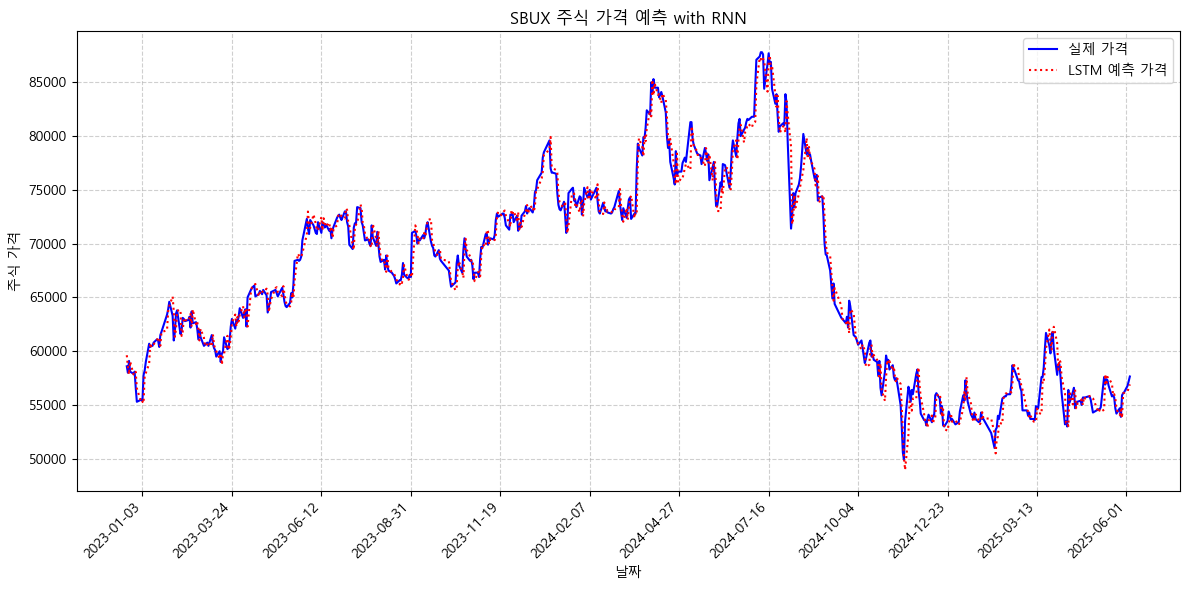

In [211]:
plt.plot(test_dataset.dates, y_test_rescaled, label='실제 가격', color='blue')
plt.plot(test_dataset.dates, lstm_test_predictions_rescaled, label='LSTM 예측 가격', color='red', linestyle=':')
plt.xlabel('날짜')
plt.ylabel('주식 가격')
plt.title('SBUX 주식 가격 예측 with RNN')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=15))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [212]:
lstm_mse = np.mean((y_test_rescaled - lstm_test_predictions_rescaled)**2)
print(f'LSTM 모델 테스트 MSE (원래 스케일): {lstm_mse:.4f}')

LSTM 모델 테스트 MSE (원래 스케일): 1461932.9580


- 2238727.3984
- 2150566.6234 _ 히든사이즈 추가
- 3453242.7522
- 2263272.3554
- 1790951.6427 _ 히든사이즈 추가
- 1730216.9764 _ 배치사이즈 추가

- 1499104.1319 _ 조기종료